### Requirements



| Module | Objective                                | 
| ------ | ---------------------------------------- |
| 1      | Predict high-priority incidents           |
| 2      | Forecast incident volumes              d |
| 3      | Auto-tag tickets (priority + departmented |
| 4      | Predict RFC failure                   ted |


### Dependencies

In [40]:
import pandas as pd
import numpy as np
import logging
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier 
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix,precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import pymysql
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

In [29]:
!pip install shap

### Load Data

In [31]:
db_config = {
    "host": "2025",
    "user": "usm",
    "password": "pwd",
    "database": "pro",
    "cursorclass": pymysql.cursors.DictCursor
}

connection = pymysql.connect(**db_config)

try:
    with connection.cursor() as cursor:
        cursor.execute("SHOW TABLES;")
        tables = [row[f'Tables_in_{db_config["database"]}'] for row in cursor.fetchall()]
        print(f"\n🔍 Tables found: {len(tables)}\n{'-'*40}")
        for t in tables:
            print(t)

        for table in tables:
            print(f"\n📄 Inspecting Table: `{table}`")
            
            cursor.execute(f"DESCRIBE `{table}`;")
            columns = [col['Field'] for col in cursor.fetchall()]
            print(f"Columns: {columns}")
            
            cursor.execute(f"SELECT COUNT(*) as count FROM `{table}`;")
            count = cursor.fetchone()["count"]
            print(f"Row Count: {count}")

            cursor.execute(f"SELECT * FROM `{table}`;")
            df = pd.DataFrame(cursor.fetchall())
            df.to_excel('ITSM_Client_Project.xlsx',index=False)
            print("Sample Rows:")
            #print(sample)
finally:
    connection.close()



🔍 Tables found: 1
----------------------------------------
dataset_list

📄 Inspecting Table: `dataset_list`
Columns: ['CI_Name', 'CI_Cat', 'CI_Subcat', 'WBS', 'Incident_ID', 'Status', 'Impact', 'Urgency', 'Priority', 'number_cnt', 'Category', 'KB_number', 'Alert_Status', 'No_of_Reassignments', 'Open_Time', 'Reopen_Time', 'Resolved_Time', 'Close_Time', 'Handle_Time_hrs', 'Closure_Code', 'No_of_Related_Interactions', 'Related_Interaction', 'No_of_Related_Incidents', 'No_of_Related_Changes', 'Related_Change']
Row Count: 46606
Sample Rows:


In [32]:
df.sample(5)

,CI_Name,CI_Cat,CI_Subcat,WBS,Incident_ID,Status,Impact,Urgency,Priority,number_cnt,...,Reopen_Time,Resolved_Time,Close_Time,Handle_Time_hrs,Closure_Code,No_of_Related_Interactions,Related_Interaction,No_of_Related_Incidents,No_of_Related_Changes,Related_Change
2513,SUB000456,subapplication,Web Based Application,WBS000073,IM0002629,Closed,4,4,4,0.205805799,...,,04-10-2013 11:12,04-10-2013 11:12,"0,508611111",Software,1,SD0005607,,,
15432,CBD001205,computer,Banking Device,WBS000146,IM0015641,Closed,2,2,2,0.080617806,...,,,21-11-2013 14:49,"1,87,22,22,222",,1,SD0044602,,,
1118,SBA000296,application,Server Based Application,WBS000053,IM0001217,Closed,3,3,3,0.06783613,...,,,01-10-2013 12:44,"0,354166667",Software,1,SD0001480,,,
35279,SBA000063,application,Server Based Application,WBS000264,IM0035586,Closed,5,5,5,0.72804626,...,,17-02-2014 10:26,17-02-2014 10:26,"0,241388889",Other,2,#MULTIVALUE,,,
15484,SUB000424,subapplication,Web Based Application,WBS000073,IM0015693,Closed,4,4,4,0.440523571,...,,22-11-2013 11:18,22-11-2013 11:19,"9,26,02,77,778",Other,1,SD0044665,,,


In [33]:
df = pd.read_excel('ITSM_Client_Project.xlsx')  

df.info()
df.head()
print(df['Priority'].value_counts(dropna=False))
print(df['Impact'].value_counts(dropna=False))
print(df['Urgency'].value_counts(dropna=False))
df[['Open_Time', 'Resolved_Time', 'Close_Time']].head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46606 entries, 0 to 46605
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   CI_Name                     46606 non-null  object 
 1   CI_Cat                      46495 non-null  object 
 2   CI_Subcat                   46495 non-null  object 
 3   WBS                         46606 non-null  object 
 4   Incident_ID                 46606 non-null  object 
 5   Status                      46606 non-null  object 
 6   Impact                      46606 non-null  object 
 7   Urgency                     46606 non-null  object 
 8   Priority                    45226 non-null  float64
 9   number_cnt                  46606 non-null  float64
 10  Category                    46606 non-null  object 
 11  KB_number                   46606 non-null  object 
 12  Alert_Status                46606 non-null  object 
 13  No_of_Reassignments         466

,Open_Time,Resolved_Time,Close_Time
0,05-02-2012 13:32,04-11-2013 13:50,04-11-2013 13:51
1,12-03-2012 15:44,02-12-2013 12:36,02-12-2013 12:36
2,29-03-2012 12:36,13-01-2014 15:12,13-01-2014 15:13
3,17-07-2012 11:49,14-11-2013 09:31,14-11-2013 09:31
4,10-08-2012 11:01,08-11-2013 13:55,08-11-2013 13:55


In [34]:
df1=df.copy()

### Module 1

Predicting High Priority Tickets


## Base Model


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.96      0.98      8906
           1       0.19      0.60      0.28       140

    accuracy                           0.95      9046
   macro avg       0.59      0.78      0.63      9046
weighted avg       0.98      0.95      0.97      9046

ROC AUC Score: 0.8790161528343653


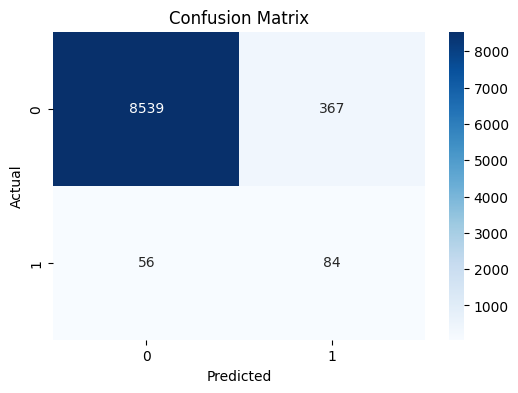

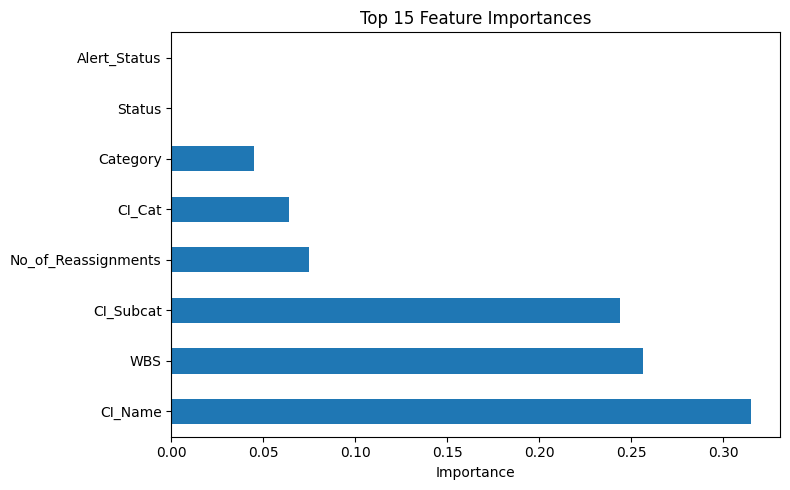

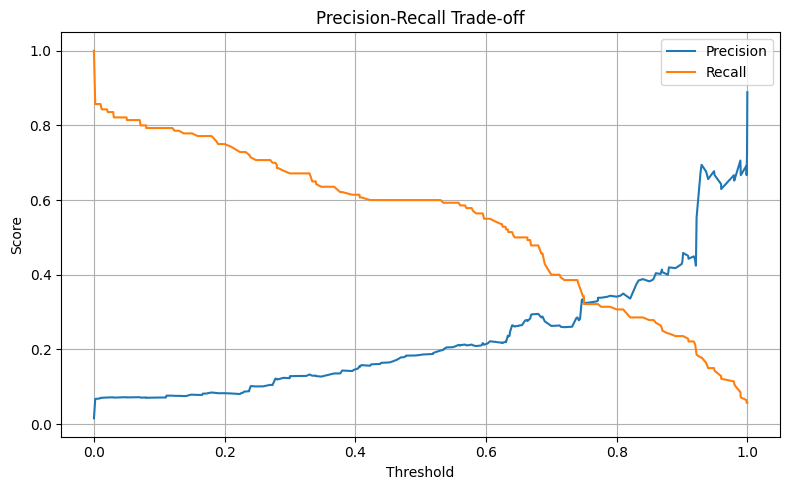

In [42]:
df = df[df['Priority'].notnull()]
df['is_high_priority'] = df['Priority'].apply(lambda x: 1 if x in [1.0, 2.0] else 0)

features = [
    'CI_Name', 'CI_Cat', 'CI_Subcat', 'WBS', 'Status',
    'Category', 'No_of_Reassignments', 'Alert_Status'
]
X = df[features]
y = df['is_high_priority']


X = X.replace(['NS', '-', ''], pd.NA)

cat_cols = X.select_dtypes(include='object').columns.tolist()

for col in X.columns:
    if col in cat_cols:
        X[col] = X[col].fillna(X[col].mode()[0])
    else:
        X[col] = X[col].fillna(X[col].median())

encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X[cat_cols] = encoder.fit_transform(X[cat_cols])


X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)


model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
model.fit(X_train, y_train)


y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_prob))

# Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


importances = pd.Series(model.feature_importances_, index=X.columns)
importances.nlargest(15).plot(kind='barh', figsize=(8, 5))
plt.title("Top 15 Feature Importances")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

plt.figure(figsize=(8, 5))
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision-Recall Trade-off")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Enhancements

2025-06-15 00:31:08,102 - Resampled training set size: (71240, 8), Class 1 ratio: 0.5000
C:\Users\Bhumi\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:31:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
2025-06-15 00:31:08,660 - XGBoost Classification Report


              precision    recall  f1-score   support

           0       1.00      0.82      0.90      8906
           1       0.07      0.89      0.14       140

    accuracy                           0.83      9046
   macro avg       0.54      0.86      0.52      9046
weighted avg       0.98      0.83      0.89      9046

XGBoost AUC: 0.9377033139777357
[LightGBM] [Info] Number of positive: 35620, number of negative: 35620
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002226 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1623
[LightGBM] [Info] Number of data points in the train set: 71240, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


2025-06-15 00:31:09,600 - LightGBM Classification Report


              precision    recall  f1-score   support

           0       1.00      0.97      0.98      8906
           1       0.27      0.78      0.40       140

    accuracy                           0.96      9046
   macro avg       0.63      0.87      0.69      9046
weighted avg       0.99      0.96      0.97      9046

LightGBM AUC: 0.9482876712328768


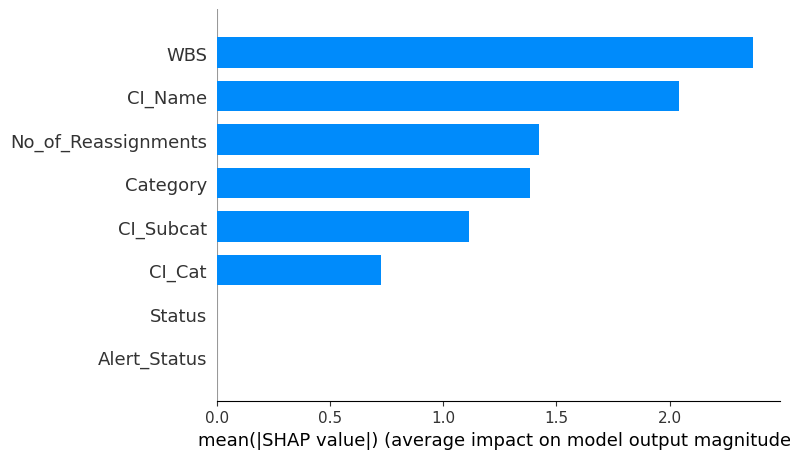

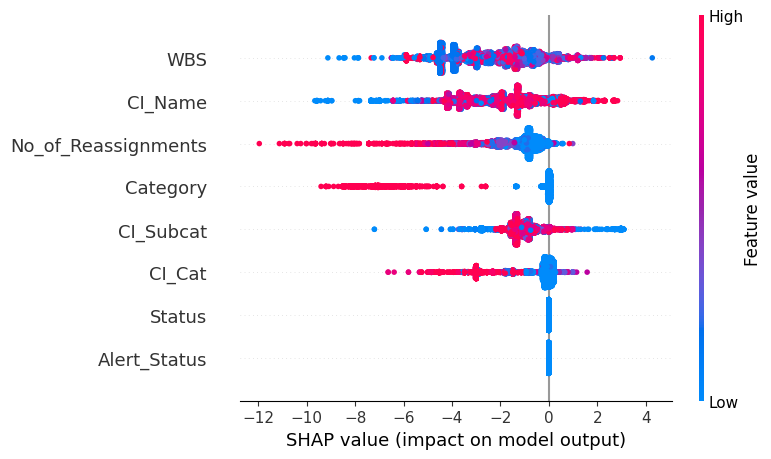

In [45]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')

sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_train, y_train)
logging.info(f"Resampled training set size: {X_resampled.shape}, Class 1 ratio: {sum(y_resampled)/len(y_resampled):.4f}")

xgb_model = XGBClassifier(scale_pos_weight=(len(y_train[y_train==0])/len(y_train[y_train==1])), use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_resampled, y_resampled)
xgb_pred = xgb_model.predict(X_test)
xgb_prob = xgb_model.predict_proba(X_test)[:, 1]

logging.info("XGBoost Classification Report")
print(classification_report(y_test, xgb_pred))
print("XGBoost AUC:", roc_auc_score(y_test, xgb_prob))

lgbm_model = LGBMClassifier(class_weight='balanced', random_state=42)
lgbm_model.fit(X_resampled, y_resampled)
lgbm_pred = lgbm_model.predict(X_test)
lgbm_prob = lgbm_model.predict_proba(X_test)[:, 1]

logging.info("LightGBM Classification Report")
print(classification_report(y_test, lgbm_pred))
print("LightGBM AUC:", roc_auc_score(y_test, lgbm_prob))


explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test, plot_type='bar')
shap.summary_plot(shap_values, X_test) 


## Hyperparameter Tuning

Fitting 3 folds for each of 54 candidates, totalling 162 fits
[LightGBM] [Info] Number of positive: 35620, number of negative: 35620
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004139 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1623
[LightGBM] [Info] Number of data points in the train set: 71240, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Best Params: {'class_weight': 'balanced', 'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 200, 'num_leaves': 63}
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98      8906
           1       0.27      0.71      0.39       140

    accuracy                           0.97      9046
   macro avg       0.63      0.84      0.69      9046
weighted avg       0.

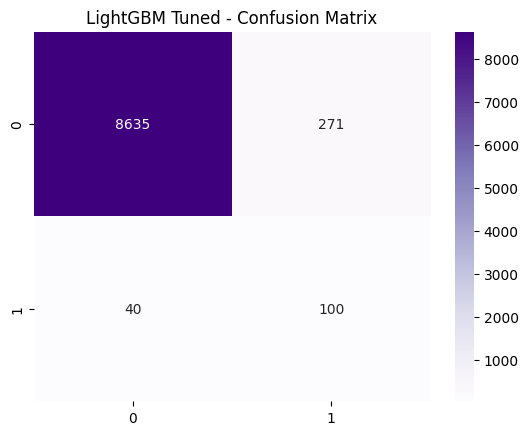

In [48]:
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier

param_grid = {
    'num_leaves': [15, 31, 63],
    'max_depth': [-1, 5, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200],
    'class_weight': ['balanced'],
}

lgbm_clf = LGBMClassifier(random_state=42)

grid = GridSearchCV(lgbm_clf, param_grid, scoring='f1', cv=3, verbose=1, n_jobs=-1)
grid.fit(X_resampled, y_resampled)

best_lgbm = grid.best_estimator_

y_pred_lgbm = best_lgbm.predict(X_test)
y_prob_lgbm = best_lgbm.predict_proba(X_test)[:, 1]

print("Best Params:", grid.best_params_)
print("Classification Report:")
print(classification_report(y_test, y_pred_lgbm))
print("AUC:", roc_auc_score(y_test, y_prob_lgbm))

sns.heatmap(confusion_matrix(y_test, y_pred_lgbm), annot=True, fmt='d', cmap='Purples')
plt.title("LightGBM Tuned - Confusion Matrix")
plt.show()


### MODULE 2: Incident Volume Forecasting

Forecast the incident volume in different fields (quarterly and annual) to enable better resource and technology planning

In [53]:
!pip install prophet

   ---------------------------------------- 0.0/13.3 MB ? eta -:--:--
   --------- ------------------------------ 3.1/13.3 MB 15.4 MB/s eta 0:00:01
   ------------------ --------------------- 6.0/13.3 MB 14.8 MB/s eta 0:00:01
   -------------------------- ------------- 8.9/13.3 MB 13.8 MB/s eta 0:00:01
   ---------------------------------- ----- 11.5/13.3 MB 13.9 MB/s eta 0:00:01
   ---------------------------------------- 13.3/13.3 MB 13.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/991.0 kB ? eta -:--:--
   ---------------------------------------- 991.0/991.0 kB 9.3 MB/s eta 0:00:00


2025-06-15 00:42:47,576 - cmd: where.exe tbb.dll
cwd: None
2025-06-15 00:42:47,689 - TBB already found in load path
2025-06-15 00:42:47,712 - input tempfile: C:\Users\Bhumi\AppData\Local\Temp\tmp9i5mct3o\rv7uyh9m.json
2025-06-15 00:42:47,718 - input tempfile: C:\Users\Bhumi\AppData\Local\Temp\tmp9i5mct3o\b6f563py.json
2025-06-15 00:42:47,722 - idx 0
2025-06-15 00:42:47,725 - running CmdStan, num_threads: None
2025-06-15 00:42:47,727 - CmdStan args: ['C:\\Users\\Bhumi\\anaconda3\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=12588', 'data', 'file=C:\\Users\\Bhumi\\AppData\\Local\\Temp\\tmp9i5mct3o\\rv7uyh9m.json', 'init=C:\\Users\\Bhumi\\AppData\\Local\\Temp\\tmp9i5mct3o\\b6f563py.json', 'output', 'file=C:\\Users\\Bhumi\\AppData\\Local\\Temp\\tmp9i5mct3o\\prophet_modeluflzzpil\\prophet_model-20250615004247.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
00:42:47 - cmdstanpy - INFO - Chain [1] start processing
2025-06-15 00:42:47,732 - Chain [1] 

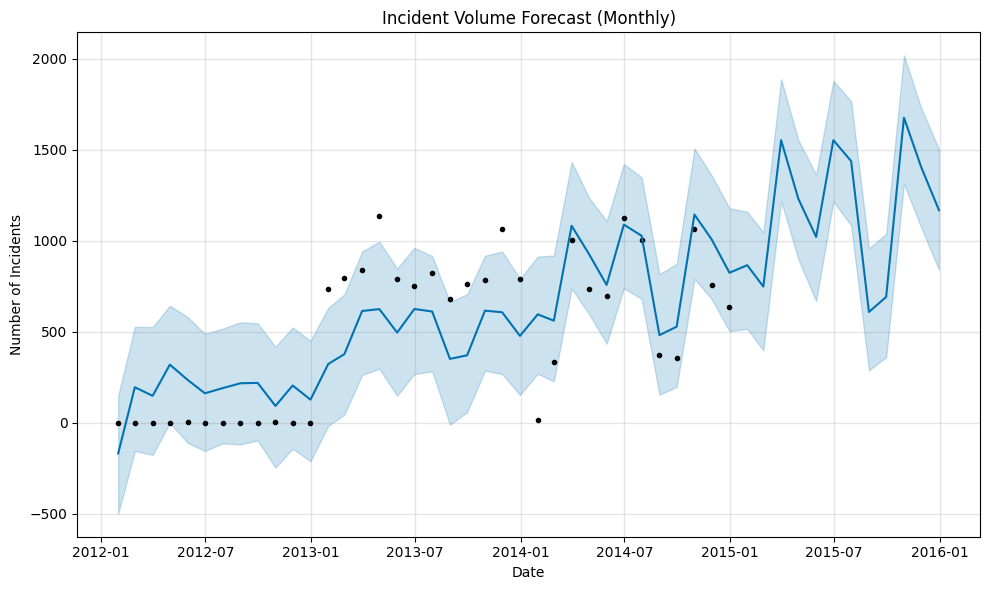

In [59]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings("ignore")

df['Open_Time'] = pd.to_datetime(df['Open_Time'], errors='coerce')
df = df.dropna(subset=['Open_Time'])

df_monthly = df.groupby(pd.Grouper(key='Open_Time', freq='M')).size().reset_index(name='volume')
df_monthly.columns = ['ds', 'y']  

model = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
model.fit(df_monthly)

future = model.make_future_dataframe(periods=12, freq='M')
forecast = model.predict(future)

model.plot(forecast)
plt.title("Incident Volume Forecast (Monthly)")
plt.xlabel("Date")
plt.ylabel("Number of Incidents")
plt.tight_layout()
plt.show()

output = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
output.to_excel("incident_volume_forecast.xlsx", index=False)


### Module 3 

Objective from Client Auto-tag the tickets with right priorities and right departments, so that reassignments and delays are reduced.

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000285 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 496
[LightGBM] [Info] Number of data points in the train set: 14414, number of used features: 5
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


2025-06-15 00:43:29,855 - LightGBM Classification Report for Priority Prediction


              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           2       0.20      0.91      0.33        53
           3       0.58      0.78      0.67       427
           4       0.89      0.78      0.83      1806
           5       0.89      0.82      0.85      1318

    accuracy                           0.79      3604
   macro avg       0.51      0.66      0.54      3604
weighted avg       0.84      0.79      0.81      3604

LightGBM AUC (weighted OVR): AUC not computed (check class coverage)


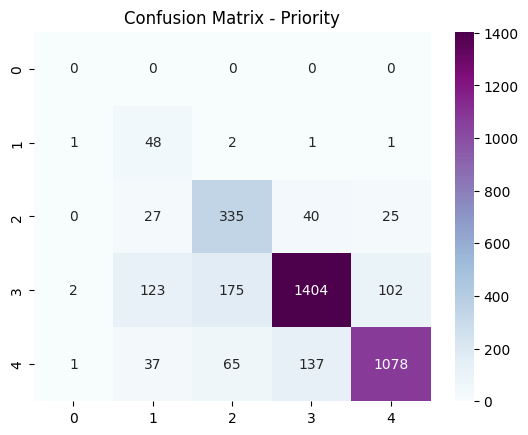

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003621 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 498
[LightGBM] [Info] Number of data points in the train set: 14414, number of used features: 5
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

2025-06-15 00:43:31,375 - LightGBM Classification Report for CI_Cat Prediction


                   precision    recall  f1-score   support

      application       1.00      1.00      1.00      2537
         computer       1.00      1.00      1.00       288
         database       1.00      1.00      1.00        14
    displaydevice       1.00      1.00      1.00        18
         hardware       1.00      1.00      1.00        42
networkcomponents       0.91      1.00      0.95        10
officeelectronics       1.00      1.00      1.00        11
         software       1.00      1.00      1.00        22
          storage       1.00      1.00      1.00        58
   subapplication       1.00      1.00      1.00       604

         accuracy                           1.00      3604
        macro avg       0.99      1.00      1.00      3604
     weighted avg       1.00      1.00      1.00      3604

Number of CI_Cat classes: 10


In [62]:
import pandas as pd
import numpy as np
import logging
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(message)s")


df = df[df['Priority'].notnull() & df['CI_Cat'].notnull()]
df['Priority'] = df['Priority'].astype(int)
df['CI_Cat'] = df['CI_Cat'].astype(str)

features = [
    'CI_Name', 'CI_Subcat', 'WBS', 'Status',
    'Category', 'Alert_Status', 'No_of_Reassignments'
]


X = df[features].copy()

X = X.replace(['NS', '-', ''], pd.NA)
cat_cols = X.select_dtypes(include='object').columns.tolist()
for col in X.columns:
    if col in cat_cols:
        X[col] = X[col].fillna(X[col].mode()[0])
    else:
        X[col] = X[col].fillna(X[col].median())

# Encode
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X[cat_cols] = encoder.fit_transform(X[cat_cols])


y = df['Priority']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42, test_size=0.2)


lgbm_model = LGBMClassifier(class_weight='balanced', random_state=42)
lgbm_model.fit(X_train, y_train)

lgbm_pred = lgbm_model.predict(X_test)
lgbm_prob = lgbm_model.predict_proba(X_test)

try:
    auc = roc_auc_score(y_test, lgbm_prob, multi_class='ovr', average='weighted')
except:
    auc = "AUC not computed (check class coverage)"

logging.info("LightGBM Classification Report for Priority Prediction")
print(classification_report(y_test, lgbm_pred))
print("LightGBM AUC (weighted OVR):", auc)

sns.heatmap(confusion_matrix(y_test, lgbm_pred), annot=True, fmt='d', cmap='BuPu')
plt.title("Confusion Matrix - Priority")
plt.show()


y2 = df['CI_Cat']
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y2, stratify=y2, random_state=42, test_size=0.2)

lgbm_model2 = LGBMClassifier(class_weight='balanced', random_state=42)
lgbm_model2.fit(X_train2, y_train2)

y_pred2 = lgbm_model2.predict(X_test2)
y_prob2 = lgbm_model2.predict_proba(X_test2)

logging.info("LightGBM Classification Report for CI_Cat Prediction")
print(classification_report(y_test2, y_pred2))
print("Number of CI_Cat classes:", len(np.unique(y_test2)))

out_df = X_test.copy()
out_df['True_Priority'] = y_test
out_df['Pred_Priority'] = lgbm_pred
out_df['True_CI_Cat'] = y_test2.values
out_df['Pred_CI_Cat'] = y_pred2
out_df.to_excel("auto_tagging_lgbm_predictions.xlsx", index=False)


### MODULE 4: Predict RFC Failure / Misconfiguration
 
Objective (from the client doc)
Predict RFCs (Requests for Change) and possible failure or misconfiguration of ITSM assets, so the client can proactively manage risk.

2025-06-15 00:44:56,865 - Total RFC records: 252
2025-06-15 00:44:56,869 - RFC Failure distribution:
rfc_failed
0    224
1     28
Name: count, dtype: int64


[LightGBM] [Info] Number of positive: 179, number of negative: 179
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000723 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 226
[LightGBM] [Info] Number of data points in the train set: 358, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

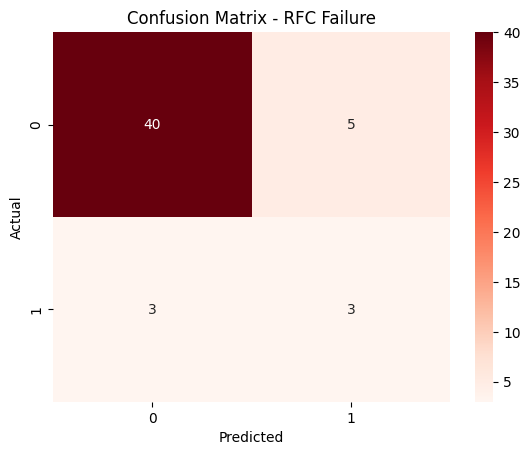

In [65]:
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(message)s")


df_rfc = df[df['Related_Change'].notna() & df['Closure_Code'].notna()].copy()
logging.info(f"Total RFC records: {df_rfc.shape[0]}")


failure_labels = ['Other', 'Failed', 'Misconfiguration', 'Rollback']
df_rfc['rfc_failed'] = df_rfc['Closure_Code'].apply(lambda x: 1 if str(x).strip().lower() in [f.lower() for f in failure_labels] else 0)
logging.info(f"RFC Failure distribution:\n{df_rfc['rfc_failed'].value_counts()}")


features = [
    'CI_Name', 'CI_Cat', 'CI_Subcat', 'WBS',
    'Status', 'Alert_Status', 'Category',
    'No_of_Reassignments', 'No_of_Related_Incidents',
    'No_of_Related_Interactions'
]

X = df_rfc[features].copy()
y = df_rfc['rfc_failed']


X = X.replace(['NS', '-', ''], pd.NA)
cat_cols = X.select_dtypes(include='object').columns.tolist()

for col in X.columns:
    if col in cat_cols:
        X[col] = X[col].fillna(X[col].mode()[0])
    else:
        X[col] = X[col].fillna(X[col].median())

encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X[cat_cols] = encoder.fit_transform(X[cat_cols])


X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_train, y_train)


lgbm_model = LGBMClassifier(class_weight='balanced', random_state=42)
lgbm_model.fit(X_resampled, y_resampled)

y_pred = lgbm_model.predict(X_test)
y_prob = lgbm_model.predict_proba(X_test)[:, 1]


print("\n RFC Failure Prediction Report")
print(classification_report(y_test, y_pred))
print("AUC Score:", roc_auc_score(y_test, y_prob))

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Reds')
plt.title("Confusion Matrix - RFC Failure")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


out_df = X_test.copy()
out_df['Actual_Failure'] = y_test
out_df['Predicted_Failure'] = y_pred
out_df['Probability'] = y_prob
out_df.to_excel("rfc_failure_predictions.xlsx", index=False)


| Metric                  | Value | Comment                                |
| ----------------------- | ----- | -------------------------------------- |
| **Accuracy**            | 84%   | Good overall                           |
| **Precision (Class 1)** | 0.38  | Acceptable given low sample size (6)   |
| **Recall (Class 1)**    | 0.50  | Captures half of all actual faile  s ✅ |
| **F1 Score (Class 1)**  | 0.43  | Balanced metric for low-support class  |
| **AUC**                 | 0.82  | Excellent discriminatory abty    🔥    |
